# Inverting Gradients - How easy is it to break privacy in federated learning?

这个笔记本展示了一个**大（或更大）批量图像梯度反演**的例子，这是在《反演梯度——联邦学习中破坏隐私有多容易？》一文中描述的¹。该设置是一个未经训练的 ResNet32-10，联邦学习算法是**fedSGD**。

论文链接：[https://proceedings.neurips.cc/paper/2020/hash/c4ede56bbd98819ae6112b20ac6bf145-Abstract.html](^1^)

This is basically the experiment of Fig.6 in this paper.

# 摘要
联邦学习的思想是在服务器上协同训练一个神经网络。每个用户接收网络的当前权重，并轮流根据本地数据发送参数更新（梯度）。这种协议不仅旨在高效地训练神经网络，而且还为用户提供隐私保护，因为他们的输入数据保留在设备上，只有参数梯度被共享。但是共享参数梯度有多安全？以前的攻击提供了一种错误的安全感，因为它们只在人为的设置中成功——即使是对于单个图像。然而，通过利用一种与幅度无关的损失函数以及基于对抗攻击的优化策略，我们展示了从参数梯度的知识中忠实地重建高分辨率图像是可能的，并证明了这种隐私的破坏甚至对于训练好的深度网络也是可能的。我们分析了架构和参数对重建输入图像的难度的影响，并证明了任何输入到全连接层的数据都可以独立于剩余架构的分析地重建。最后，我们讨论了实际遇到的设置，并显示即使对多个迭代或多个图像进行梯度平均也不能保护用户在联合学习应用中的隐私。

# 开始

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

# 初始化 cfg 对象和系统设置：

这将加载完整的配置对象。 这包括“cfg.case”的用例和威胁模型的配置以及“cfg.attack”的超参数和攻击实施。 所有参数都可以在下面修改，或者用“overrides=”覆盖，就像它们是命令行参数一样。

In [2]:
cfg = breaching.get_config(overrides=["case=6_large_batch_cifar"])
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

/root/miniconda3/lib/python3.8/site-packages/breaching/__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case large_batch_cifar with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

# 在这里修改配置选项 

您可以使用“.attribute”访问权限来修改“攻击”或“案例”的任何配置：

In [3]:
cfg.case.data.partition="balanced" # 100 unique CIFAR-100 images
cfg.case.user.user_idx = 0

cfg.case.user.provide_labels = False
cfg.attack.label_strategy = "yin" # also works here, as labels are unique

# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 5e-4

# 实例化所有各方

以下几行生成“服务器”、“用户”和“攻击者”对象并打印其配置的概述。

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture ResNet32-10 loaded with 46,429,060 parameters and 24,673 buffers.
Overall this is a data ratio of     151:1 for target shape [100, 3, 32, 32] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 100

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR100
    user: 0
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet32-10
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.0005. p=1

# 模拟受攻击的 FL 协议

这种交换是联邦学习协议中单个查询的模拟。 服务器发出“server_payload”，用户根据其私有本地数据计算更新。 该用户更新是“shared_data”，并且包含例如最简单情况下模型的参数梯度。 `true_user_data` 也由 `.compute_local_updates` 返回，但当然不会转发到服务器或攻击者，仅用于（我们的）分析。

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 0 in model mode: eval.


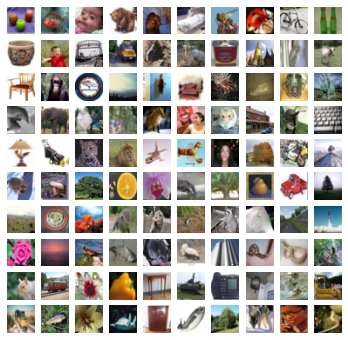

In [6]:
user.plot(true_user_data)

# 重建用户数据：

现在我们发起攻击，仅基于“server_payload”和“shared_data”重建用户数据。

您可以提前中断计算以查看部分解决方案。

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Recovered labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] through strategy yin.
| It: 1 | Rec. loss: 0.0145 |  Task loss: 27.5015 | T: 1.24s
| It: 1001 | Rec. loss: 0.0005 |  Task loss: 24.3326 | T: 993.52s
| It: 2001 | Rec. loss: 0.0005 |  Task loss: 24.4049 | T: 985.35s
| It: 3001 | Rec. loss: 0.0005 |  Task loss: 24.1832 | T: 985.67s
| It: 4001 | Rec. loss: 0.0005 |  Task loss: 24.1126 | T: 985.38s
| It: 5001 | Rec. loss: 0.0005 |  Task loss: 24.0871 | T: 985.15s
| It: 6001 | Rec. loss: 0.0005 |  Task loss: 24.2183 | T: 985.25s
| It: 7001 | Rec. loss: 0.0005 |  Task loss: 23.8831 | T: 985.19s
| It: 8001 | Rec. loss: 0.0005 |  Task loss: 24

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [8]:
!pip install lpips

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [9]:
!pip install pytorch_wavelets

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [10]:
!pip install kornia

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [16]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Files already downloaded and verified
METRICS: | MSE: 0.0803 | PSNR: 11.49 | FMSE: 1.1467e+01 | LPIPS: 0.20|
 R-PSNR: 11.67 | IIP-pixel: 9.00% | SSIM: nan | max R-PSNR: 19.19 | max SSIM: nan | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

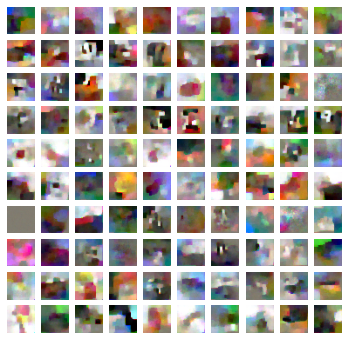

In [15]:
user.plot(reconstructed_user_data)

# 注释：
* 标签恢复在这个例子中工作得相当不错。特别是当标签在默认设置中是唯一的时候。
* 这里有趣的部分不是大多数图像是无法识别的（它们是），而是少数几个图像被重建得非常好。
* 另外请注意，这个模型对于在 CIFAR-100 上进行的实验来说是相当大的。